# 01 – Data Ingestion & Schema Setup

**Goals:**  
- Connect to SQLite database with our `schema.sql`  
- Read price CSV(s) from `data/` and compute daily returns  
- Insert those returns into the `returns` table

In [28]:
import os
from sqlalchemy import create_engine

# Define path for the SQLite database file (in the data/ folder)
db_path = os.path.join("..", "data", "portfolio.db")

# Create a SQLAlchemy engine (creates the file if it doesn't exist)
engine = create_engine(f"sqlite:///{db_path}")

print("Engine ready, database file at:", db_path)

Engine ready, database file at: ..\data\portfolio.db


### 1.2 Execute Schema Statements

Our `sql/schema.sql` contains two statements (`DROP TABLE…;` and `CREATE TABLE…;`).  
SQLite only executes one SQL statement at a time, so we’ll split on `;` and run each.

In [29]:
import os

# 1.2 Load the DDL file
schema_path = os.path.join("..", "sql", "schema.sql")
with open(schema_path, "r") as f:
    ddl = f.read()

# 1.2 Execute each statement separately
with engine.begin() as conn:
    for stmt in ddl.split(";"):
        stmt = stmt.strip()
        if stmt:                      # skip empty lines
            conn.exec_driver_sql(stmt)
print("Schema executed successfully.")

Schema executed successfully.


### 1.3 Verify Table Creation

Check that the `returns` table now exists in our SQLite database.

In [30]:
from sqlalchemy import text

with engine.connect() as conn:
    result = conn.exec_driver_sql(
        "SELECT name FROM sqlite_master WHERE type='table';"
    )
    tables = [row[0] for row in result]
print("Tables in database:", tables)

Tables in database: ['returns']


# 02 – Read Price CSVs & Compute Daily Returns  

In [31]:
# Install yfinance
%pip install yfinance --quiet

Note: you may need to restart the kernel to use updated packages.


In [32]:
# 2.0 Fetch data via yfinance
import os
import yfinance as yf

tickers = ["^GSPC", "AAPL", "TD"]
out_dir = os.path.join("..", "data")
os.makedirs(out_dir, exist_ok=True)

for ticker in tickers:
    # Download daily data
    df = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)
    # Save to CSV
    filename = f"{ticker.replace('^','')}.csv"  # removes ^ from filename
    csv_path = os.path.join(out_dir, filename)
    df.to_csv(csv_path)
    print(f"Saved {csv_path}")

Saved ..\data\GSPC.csv
Saved ..\data\AAPL.csv
Saved ..\data\TD.csv


C:\Users\User\AppData\Local\Temp\ipykernel_2980\3132212848.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)
C:\Users\User\AppData\Local\Temp\ipykernel_2980\3132212848.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)
C:\Users\User\AppData\Local\Temp\ipykernel_2980\3132212848.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-01-01", end="2023-12-31", progress=False)


In [33]:
import glob
print(glob.glob(os.path.join("..","data","*.csv")))

['..\\data\\AAPL.csv', '..\\data\\GSPC.csv', '..\\data\\TD.csv']


### 2.1 Load CSVs and Compute Daily Returns

In [34]:
import pandas as pd

# Define your data path
data_path = os.path.join("..", "data")
tickers = ["GSPC", "AAPL", "TD"]

# Empty DataFrame to collect all returns
all_returns = []

for ticker in tickers:
    file_path = os.path.join(data_path, f"{ticker}.csv")
    columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
    df = pd.read_csv(file_path, skiprows=2, names=columns, parse_dates=["Date"])
    df = df[["Date", "Close"]].copy()
    df["Ticker"] = ticker

    all_returns.append(df)  # ✅ append to the list!
    print(df.head())        # optional sanity check

# Combine into one DataFrame
returns_df = pd.concat(all_returns)
returns_df.head()

         Date        Close Ticker
0        Date          NaN   GSPC
1  2018-01-02  2695.810059   GSPC
2  2018-01-03  2713.060059   GSPC
3  2018-01-04  2723.989990   GSPC
4  2018-01-05  2743.149902   GSPC
         Date      Close Ticker
0        Date        NaN   AAPL
1  2018-01-02  40.426823   AAPL
2  2018-01-03  40.419765   AAPL
3  2018-01-04  40.607529   AAPL
4  2018-01-05  41.069866   AAPL
         Date      Close Ticker
0        Date        NaN     TD
1  2018-01-02  43.149803     TD
2  2018-01-03  43.340240     TD
3  2018-01-04  43.823677     TD
4  2018-01-05  44.204548     TD


C:\Users\User\AppData\Local\Temp\ipykernel_2980\1261152407.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, skiprows=2, names=columns, parse_dates=["Date"])
C:\Users\User\AppData\Local\Temp\ipykernel_2980\1261152407.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, skiprows=2, names=columns, parse_dates=["Date"])
C:\Users\User\AppData\Local\Temp\ipykernel_2980\1261152407.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, skiprows=2, names=columns, parse_dates=["Date"])


,Date,Close,Ticker
0,Date,NaN,GSPC
1,2018-01-02,2695.810059,GSPC
2,2018-01-03,2713.060059,GSPC
3,2018-01-04,2723.989990,GSPC
4,2018-01-05,2743.149902,GSPC


### 2.2 Compute Daily Returns

In [35]:
# Drop any rows where the Close price is NaN (these came from header rows)
returns_df = returns_df.dropna(subset=["Close"])

# Sort by ticker then date
returns_df = returns_df.sort_values(["Ticker", "Date"])

# Compute percent change per ticker
returns_df["Daily_Return"] = (
    returns_df
    .groupby("Ticker")["Close"]
    .pct_change()
    .fillna(0)      # first row per ticker goes to 0
)

# Keep only the columns we need for the DB
returns_df = returns_df[["Date", "Ticker", "Daily_Return"]]

# Sanity check
returns_df.head(8)

,Date,Ticker,Daily_Return
1,2018-01-02,AAPL,0.000000
2,2018-01-03,AAPL,-0.000175
3,2018-01-04,AAPL,0.004645
4,2018-01-05,AAPL,0.011386
5,2018-01-08,AAPL,-0.003714
6,2018-01-09,AAPL,-0.000115
7,2018-01-10,AAPL,-0.000230
8,2018-01-11,AAPL,0.005680


### 2.3 Insert Returns into `returns` Table

In [36]:
to_insert = returns_df.rename(columns={
    "Date": "date",
    "Ticker": "ticker",
    "Daily_Return": "daily_return"
})

# Insert into SQLite via SQLAlchemy
with engine.begin() as conn:
    to_insert.to_sql(
        name="returns",
        con=conn,
        if_exists="append",
        index=False
    )

print(f"✅ Inserted {len(to_insert)} rows into 'returns' table.")

✅ Inserted 4527 rows into 'returns' table.


#### Verify Insertion

In [37]:
from sqlalchemy import text

with engine.connect() as conn:
    total = conn.exec_driver_sql("SELECT COUNT(*) FROM returns").scalar()
    sample = conn.exec_driver_sql(
        "SELECT * FROM returns ORDER BY date, ticker LIMIT 5"
    ).fetchall()

print(f"Total rows in 'returns': {total}")
print("Sample rows:", sample)

Total rows in 'returns': 4527
Sample rows: [('2018-01-02', 'AAPL', 0.0), ('2018-01-02', 'GSPC', 0.0), ('2018-01-02', 'TD', 0.0), ('2018-01-03', 'AAPL', -0.00017456701953444398), ('2018-01-03', 'GSPC', 0.006398818768781567)]


# 03 - Data Exploration & Querying

### 3.1 Load Returns from SQL

In [38]:
import pandas as pd

# Query all returns into a DataFrame
query = "SELECT date, ticker, daily_return FROM returns"
returns_sql = pd.read_sql(query, con = engine, parse_dates = ["date"])

# Show a quick pivot to check
print(returns_sql.head())

        date ticker  daily_return
0 2018-01-02   AAPL      0.000000
1 2018-01-03   AAPL     -0.000175
2 2018-01-04   AAPL      0.004645
3 2018-01-05   AAPL      0.011386
4 2018-01-08   AAPL     -0.003714


### 3.2 Pivot to Wide Format
Transform the long table into a matrix

In [39]:
# Pivot so that each column is a ticker, indexed by the date
returns_wide = returns_sql.pivot(
    index = "date",
    columns = "ticker",
    values = "daily_return"
).sort_index()

# Check the shape and head
print("Wide returns shape: ", returns_wide.shape)
returns_wide.head()

Wide returns shape:  (1509, 3)


ticker,AAPL,GSPC,TD
date,,,
2018-01-02,0.000000,0.000000,0.000000
2018-01-03,-0.000175,0.006399,0.004413
2018-01-04,0.004645,0.004029,0.011154
2018-01-05,0.011386,0.007034,0.008691
2018-01-08,-0.003714,0.001662,-0.002485


### 3.3 Calculate Mean & Covariance

In [40]:
import numpy as np

# Mean daily returns
mean_returns = returns_wide.mean()

# Covariance matrix of daily returns
cov_matrix = returns_wide.cov()

print("Mean returns:\n", mean_returns.round(5))
print("\nCovariance matrix:\n", cov_matrix.round(8))

Mean returns:
 ticker
AAPL    0.00123
GSPC    0.00046
TD      0.00035
dtype: float64

Covariance matrix:
 ticker      AAPL      GSPC        TD
ticker                              
AAPL    0.000398  0.000207  0.000146
GSPC    0.000207  0.000169  0.000145
TD      0.000146  0.000145  0.000240


# 04 - Portfolio Optimization

### 4.1 Optimization Helper Functions

In [41]:
import numpy as np
from scipy.optimize import minimize

# Number of assets
assets = list(returns_wide.columns)
n = len(assets)

# Helper portolio variance
def port_variance(weights, cov_matrix):
    return weights.T @ cov_matrix.values @ weights

# Helper portfolio return
def port_return(weights, mean_returns):
    return weights @ mean_returns.values

# Contrain weights sum to 1
cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1})

# Bounds: no shorting so weights between 0 and 1
bnds = tuple((0,1) for _ in range(n))

### 4.2 Find Minimum Variance Portfolio

In [42]:
# Set target to average of mean_returns
target = mean_returns.mean()

# Add constraint: portfolio return = target
cons_target = (
    cons,
    {'type': 'eq', 'fun': lambda w: port_return(w, mean_returns) - target}
)

# Initial guess: even weights
w0 = np.array(n * [1. / n])

# Run optimization
opt = minimize(
    fun=port_variance,
    x0=w0,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bnds,
    constraints=cons_target
)

min_var_weights = opt.x
min_var_weights = pd.Series(min_var_weights, index=assets)

print("Minimum‐Variance Portfolio Weights for target return", round(target,5))
print(min_var_weights.round(4))
print("Portfolio variance:", round(port_variance(min_var_weights, cov_matrix),8))
print("Portfolio return:", round(port_return(min_var_weights, mean_returns),5))

Minimum‐Variance Portfolio Weights for target return 0.00068
AAPL    0.3333
GSPC    0.3333
TD      0.3333
dtype: float64
Portfolio variance: 0.00020034
Portfolio return: 0.00068


#### 4.3 Compute & Plot Efficient Frontier

In [43]:
import numpy as np
from scipy.optimize import minimize

# Define risk-free rate (daily)
rf = 0.000006

def neg_sharpe(weights, mean_returns, cov_matrix, rf):
    """Negative Sharpe ratio for given weights."""
    ret = weights @ mean_returns.values
    var = weights.T @ cov_matrix.values @ weights
    return - (ret - rf) / np.sqrt(var)

# Constraints: sum of weights = 1
cons_sharpe = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)

# Initial guess
w0 = np.array(n * [1. / n])

# Run optimization
opt_sr = minimize(
    fun=neg_sharpe,
    x0=w0,
    args=(mean_returns, cov_matrix, rf),
    method='SLSQP',
    bounds=bnds,
    constraints=cons_sharpe
)

tangent_weights = pd.Series(opt_sr.x, index=assets)
tangent_ret   = port_return(opt_sr.x, mean_returns)
tangent_var   = port_variance(opt_sr.x, cov_matrix)
tangent_sharpe = (tangent_ret - rf) / np.sqrt(tangent_var)

print("Tangent Portfolio Weights:\n", tangent_weights.round(4))
print(f"Return: {tangent_ret:.5f}, Variance: {tangent_var:.8f}, Sharpe: {tangent_sharpe:.3f}")


Tangent Portfolio Weights:
 AAPL    1.0
GSPC    0.0
TD      0.0
dtype: float64
Return: 0.00123, Variance: 0.00039792, Sharpe: 0.061


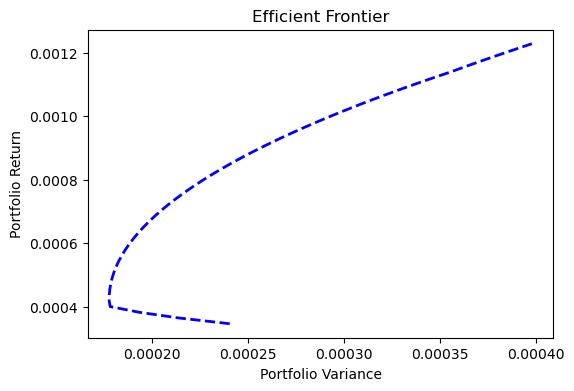

In [44]:
import matplotlib.pyplot as plt

# Generate target returns
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
ef_vars = []
ef_rets = []

for tr in target_returns:
    cons_tr = (
        cons,
        {'type': 'eq', 'fun': lambda w, tr=tr: port_return(w, mean_returns) - tr}
    )
    res = minimize(
        fun=port_variance,
        x0=w0,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bnds,
        constraints=cons_tr
    )
    if res.success:
        ef_vars.append(port_variance(res.x, cov_matrix))
        ef_rets.append(port_return(res.x, mean_returns))

# Plot
plt.figure(figsize=(6,4))
plt.plot(ef_vars, ef_rets, 'b--', lw=2)
plt.xlabel("Portfolio Variance")
plt.ylabel("Portfolio Return")
plt.title("Efficient Frontier")
plt.show()

# 05 - Summary of Results
### 5.1 Saving Results

In [45]:
# Save portfolio weights
min_var_weights.to_csv("min_variance_weights.csv", header = True)
tangent_weights.to_csv("tangent_weights.csv", header=True)

# Save and return covariance matrix
mean_returns.to_csv("mean_returns.csv", header = True)
cov_matrix.to_csv("cov_matrix.csv", header = True)

### 5.3 Portfolio Performance Summary

In [46]:
# Calculate stats for summary table

min_var_ret = port_return(min_var_weights, mean_returns)
min_var_var = port_variance(min_var_weights, cov_matrix)

tangent_ret = port_return(tangent_weights, mean_returns)
tangent_var = port_variance(tangent_weights, cov_matrix)

In [47]:
summary_df = pd.DataFrame({
    "Portfolio": ["Min-Variance", "Tangent (Max Sharpe)"],
    "Return": [min_var_ret, tangent_ret],
    "Variance": [min_var_var, tangent_var],
    "Sharpe": [None, tangent_sharpe]
})
print(summary_df)

              Portfolio    Return  Variance    Sharpe
0          Min-Variance  0.000679  0.000200       NaN
1  Tangent (Max Sharpe)  0.001229  0.000398  0.061308


# 06 - Portfolio Simulation
### 6.1 Simulate Custon Portfolio

In [50]:
# Reconnect to the SQLite database if connection was closed
import sqlite3

conn = sqlite3.connect("prices.db")  # or whatever your DB file is called

In [52]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

Empty DataFrame
Columns: [name]
Index: []
